# TensorNetworks in Neural Networks.

Here, we have a small toy example of how to use a TN inside of a fully connected neural network.

First off, let's install tensornetwork

In [56]:
# !pip install tensornetwork

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Import tensornetwork
import tensornetwork as tn
import random
import time
import pandas as pd
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
# Explainability code assistance aided by ChatGPT3.5
# 2021 Kelly, D. TensorFlow Explainable AI tutorial https://www.youtube.com/watch?v=6xePkn3-LME

# TensorNetwork layer definition

Here, we define the TensorNetwork layer we wish to use to replace the fully connected layer. Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

We TensorNetwork's NCon API to keep the code short.

In [57]:
class TNLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(TNLayer, self).__init__()
    # Create the variables for the layer.
    self.a_var = tf.Variable(tf.random.normal(shape=(32, 32, 2),
                                              stddev=1.0/32.0),
                             name="a", trainable=True)
    self.b_var = tf.Variable(tf.random.normal(shape=(32, 32, 2),
                                              stddev=1.0/32.0),
                             name="b", trainable=True)
    self.bias = tf.Variable(tf.zeros(shape=(32, 32)),
                            name="bias", trainable=True)

  def call(self, inputs):
    # Define the contraction.
    # We break it out so we can parallelize a batch using
    # tf.vectorized_map (see below).
    def f(input_vec, a_var, b_var, bias_var):
      # Reshape to a matrix instead of a vector.
      input_vec = tf.reshape(input_vec, (32, 32))

      # Now we create the network.
      a = tn.Node(a_var)
      b = tn.Node(b_var)
      x_node = tn.Node(input_vec)
      a[1] ^ x_node[0]
      b[1] ^ x_node[1]
      a[2] ^ b[2]

      # The TN should now look like this
      #   |     |
      #   a --- b
      #    \   /
      #      x

      # Now we begin the contraction.
      c = a @ x_node
      result = (c @ b).tensor

      # To make the code shorter, we also could've used Ncon.
      # The above few lines of code is the same as this:
      # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

      # Finally, add bias.
      return result + bias_var

    # To deal with a batch of items, we can use the tf.vectorized_map
    # function.
    # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
        lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
    return tf.nn.relu(tf.reshape(result, (-1, 1024)))

# Smaller model
These two models are effectively the same, but notice how the TN layer has nearly 10x fewer parameters.

In [58]:
Dense = tf.keras.layers.Dense
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     # Start Modified Layers
     TNLayer(),
     TNLayer(),
     TNLayer(),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     # Finish Modified Layers
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1024)              3072      
                                                                 
 tn_layer_15 (TNLayer)       (None, 1024)              5120      
                                                                 
 tn_layer_16 (TNLayer)       (None, 1024)              5120      
                                                                 
 tn_layer_17 (TNLayer)       (None, 1024)              5120      
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_21 (Dense)            (None, 1)                

# Training a model

You can train the TN model just as you would a normal neural network model! Here, we give an example of how to do it in Keras.

In [59]:
X = np.concatenate([np.random.randn(120, 2) + np.array([3, 3]),
                    np.random.randn(120, 2) + np.array([-3, -3]),
                    np.random.randn(120, 2) + np.array([-3, 3]),
                    np.random.randn(120, 2) + np.array([3, -3])])

Y = np.concatenate([np.ones((240)), -np.ones((240))])

In [60]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1712630954.5279925
Tue Apr  9 02:49:14 2024


In [61]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=300, verbose=2)

Epoch 1/300
15/15 - 2s - loss: 1.0034 - 2s/epoch - 122ms/step
Epoch 2/300
15/15 - 0s - loss: 1.0006 - 184ms/epoch - 12ms/step
Epoch 3/300
15/15 - 0s - loss: 1.0008 - 170ms/epoch - 11ms/step
Epoch 4/300
15/15 - 0s - loss: 0.9756 - 187ms/epoch - 12ms/step
Epoch 5/300
15/15 - 0s - loss: 0.2568 - 175ms/epoch - 12ms/step
Epoch 6/300
15/15 - 0s - loss: 0.0272 - 174ms/epoch - 12ms/step
Epoch 7/300
15/15 - 0s - loss: 0.0087 - 174ms/epoch - 12ms/step
Epoch 8/300
15/15 - 0s - loss: 0.0067 - 168ms/epoch - 11ms/step
Epoch 9/300
15/15 - 0s - loss: 0.0052 - 164ms/epoch - 11ms/step
Epoch 10/300
15/15 - 0s - loss: 0.0034 - 173ms/epoch - 12ms/step
Epoch 11/300
15/15 - 0s - loss: 0.0023 - 166ms/epoch - 11ms/step
Epoch 12/300
15/15 - 0s - loss: 8.3699e-04 - 164ms/epoch - 11ms/step
Epoch 13/300
15/15 - 0s - loss: 9.9896e-04 - 176ms/epoch - 12ms/step
Epoch 14/300
15/15 - 0s - loss: 0.0042 - 178ms/epoch - 12ms/step
Epoch 15/300
15/15 - 0s - loss: 0.0030 - 182ms/epoch - 12ms/step
Epoch 16/300
15/15 - 0s - lo

16/16 [==============================] - 0s 5ms/step


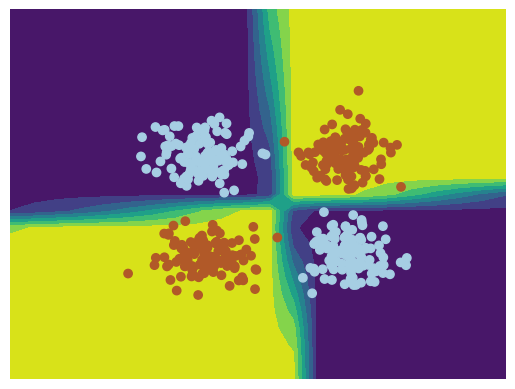

In [62]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

In [63]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1712631008.5725968
Tue Apr  9 02:50:08 2024


In [64]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1712631008.5779479
Tue Apr  9 02:50:08 2024


Saliency values saved to saliency_values.csv


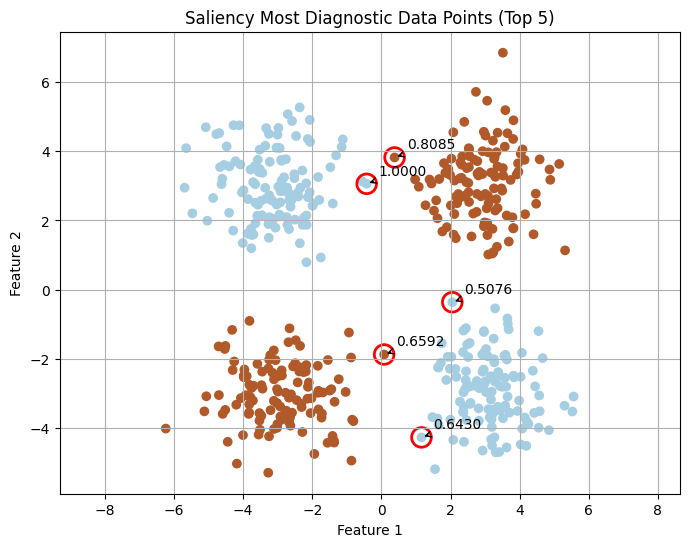

Normalized saliency values saved to normalized_saliency_values.csv
Normalized Saliency Top-k:
     Saliency
327  1.000000
37   0.808517
239  0.659226
370  0.643038
377  0.507635
Normalized Saliency Max: Saliency    1.0
dtype: float32
Normalized Saliency Min: Saliency    0.0
dtype: float32
Normalized Saliency Mean: Saliency    0.011634
dtype: float32
Normalized Saliency Median: Saliency    0.001807
dtype: float32
Normalized Saliency Mode:    Saliency
0  0.000115
1  0.002653
2  0.003782
Normalized Saliency Sum: Saliency    5.584382
dtype: float32
#
#
#
Normalized Saliency Standard Deviation: Saliency    0.076005
dtype: float32
Normalized Saliency Skewness: Saliency    10.131322
dtype: float32
Normalized Saliency Kurtosis: Saliency    108.065147
dtype: float32
Normalized Saliency Variance: Saliency    0.005777
dtype: float32
Normalized Saliency Coefficient of Variation: Saliency    653.293457
dtype: float32
#
#
#
Cumulative Sum of Normalized Saliency Values:      Saliency
0    0.000103
1 

In [65]:
# Function to compute saliency map
@tf.function
def compute_saliency(input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = tn_model(input_image)
    grads = tape.gradient(predictions, input_image)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency_map

# Function to compute saliency map using Gradient
@tf.function
def compute_gradient_saliency(input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = tn_model(input_image)
    grads = tape.gradient(predictions, input_image)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency_map

# Compute saliency map for the entire grid
def compute_saliency_map_grid():
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    input_image = np.c_[xx.ravel(), yy.ravel()]
    saliency_map = compute_saliency(tf.constant(input_image, dtype=tf.float32)).numpy()
    saliency_map = saliency_map.reshape(xx.shape)
    return xx, yy, saliency_map

# Compute and plot saliency map for the entire grid
xx, yy, saliency_map = compute_saliency_map_grid()

# Compute saliency maps for all data points
def compute_saliency_maps():
    saliency_maps = []
    for data_point in X:
        saliency_map = compute_gradient_saliency(tf.constant(data_point[None, :], dtype=tf.float32)).numpy()
        saliency_maps.append(saliency_map)
    return saliency_maps

# Find the indices of the data points with the highest saliency values
def find_top_indices(saliency_maps, top_k):
    top_indices = np.argsort(np.max(saliency_maps, axis=1))[-top_k:]
    return top_indices

def plot_most_diagnostic(top_indices, top_k, normalized_saliency_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    plt.scatter(X[top_indices, 0], X[top_indices, 1], marker='o', s=200, facecolors='none', edgecolors='r', linewidths=2)
    for i, index in enumerate(top_indices):
        plt.annotate(f'{normalized_saliency_values.iloc[index]["Saliency"]:.4f}', (X[index, 0], X[index, 1]), xytext=(X[index, 0]+0.35, X[index, 1]+0.25), arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.title(f'Saliency Most Diagnostic Data Points (Top {top_k})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Compute saliency maps for all data points
saliency_maps = compute_saliency_maps()

# Find the indices of the data points with the highest saliency values
top_k = 5  # Number of top diagnostic data points to select
top_indices = find_top_indices(saliency_maps, top_k)

# Create a DataFrame to store the saliency values
saliency_df = pd.DataFrame(data=saliency_maps, columns=["Saliency"])

# Save the saliency values to a CSV file
saliency_df.to_csv("saliency_values.csv", index=False)

print("Saliency values saved to saliency_values.csv")

# Normalizing the saliency values
normalized_saliency = (saliency_df - saliency_df.min()) / (saliency_df.max() - saliency_df.min())

# Saving the normalized saliency values to a new CSV file
normalized_saliency.to_csv("normalized_saliency_values.csv", index=False)

# Plot the most diagnostic data points
plot_most_diagnostic(top_indices, top_k, normalized_saliency)

print("Normalized saliency values saved to normalized_saliency_values.csv")
print("Normalized Saliency Top-k:")
print(normalized_saliency.nlargest(top_k, 'Saliency'))
print("Normalized Saliency Max:", normalized_saliency.max())
print("Normalized Saliency Min:", normalized_saliency.min())
print("Normalized Saliency Mean:", normalized_saliency.mean())
print("Normalized Saliency Median:", normalized_saliency.median())
print("Normalized Saliency Mode:", normalized_saliency.mode())
sum_normalized_values = normalized_saliency.sum()
print("Normalized Saliency Sum:", sum_normalized_values)
print("#")
print("#")
print("#")
print("Normalized Saliency Standard Deviation:", normalized_saliency.std())
print("Normalized Saliency Skewness:", normalized_saliency.skew())
print("Normalized Saliency Kurtosis:", normalized_saliency.kurtosis())
print("Normalized Saliency Variance:", normalized_saliency.var())
coefficient_variation = (normalized_saliency.std() / normalized_saliency.mean()) * 100
print("Normalized Saliency Coefficient of Variation:", coefficient_variation)
print("#")
print("#")
print("#")
cumulative_sum = normalized_saliency.cumsum()
print("Cumulative Sum of Normalized Saliency Values:", cumulative_sum)
mean_cumulative_sum = cumulative_sum / len(normalized_saliency)
print("Mean of Cumulative Sum of Normalized Saliency Values:", mean_cumulative_sum)
rms = np.sqrt(np.mean(normalized_saliency**2))
print("Normalized Saliency Root Mean Square:", rms)
q1 = normalized_saliency.quantile(0.25)
q2 = normalized_saliency.quantile(0.75)
iqr = q2 - q1
print("Normalized Saliency 25th Percentile:", q1)
print("Normalized Saliency 75th Percentile:", q2)
print("Normalized Saliency Interquartile Range:", iqr)

In [66]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1712631010.4922264
Tue Apr  9 02:50:10 2024
